## Kütüphaneleri Dahil Etme

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision
import os 
import time
import pandas as pd 
from torch.utils.data import Dataset,DataLoader
from skimage import io
import warnings
warnings.filterwarnings("ignore")

## Veriyi Dahil Etme

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_labels.iloc[idx, 0])
        image = io.imread(img_path)
        label = torch.tensor(int(self.img_labels.iloc[idx,1]))
        if self.transform:
            image = self.transform(image)
    
        return (image, label)

## Veri  Hazırlama

In [3]:
dataset=CustomImageDataset(annotations_file=r"C:\Users\KENAN\Desktop\Projelerle_yapay_zeka_ve_bilgisayarli_goru\f1_classification\f111.csv",
                          img_dir=r"C:\Users\KENAN\Desktop\Projelerle_yapay_zeka_ve_bilgisayarli_goru\f1_classification",
                          transform=torchvision.transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Resize(size=(28,28)),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                          ]))

## Veri Ön İşleme

In [4]:
train_set,test_set=torch.utils.data.random_split(dataset,[200,79])
train_loader=DataLoader(dataset=train_set,batch_size=1,shuffle=False)
test_loader=DataLoader(dataset=test_set,batch_size=1,shuffle=False)

## Veriyi Görselleştirme

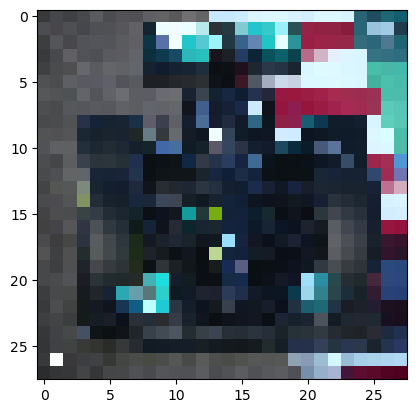

Mercedes
torch.Size([1, 3, 28, 28])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
batch_size=1
classes=["Ferrari","Mclaren","Mercedes","Redbull"]
def imshow(img):
    img=img/2 +0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
    
dataiter=iter(train_loader)
images,labels=dataiter.__next__()
imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(batch_size)))
print(images.size())

## Sequential Model Mimarisi Oluşturma

In [18]:
model=nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=4,kernel_size=(5,5)),
    nn.ELU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=4,out_channels=8,kernel_size=(3,3)),
    nn.ELU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(2,2)),
    nn.ELU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(2,2)),
    nn.ELU(),
    nn.Flatten(),
    nn.Linear(in_features=32,out_features=50),
    nn.ELU(),
    nn.Linear(in_features=50,out_features=100),
    nn.ELU(),
    nn.Linear(in_features=100,out_features=4)
    
)


In [19]:
model

Sequential(
  (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (1): ELU(alpha=1.0)
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ELU(alpha=1.0)
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1))
  (7): ELU(alpha=1.0)
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (10): ELU(alpha=1.0)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=32, out_features=50, bias=True)
  (13): ELU(alpha=1.0)
  (14): Linear(in_features=50, out_features=100, bias=True)
  (15): ELU(alpha=1.0)
  (16): Linear(in_features=100, out_features=4, bias=True)
)

## Model Eğitimi

In [20]:
start = time.time()

if torch.cuda.is_available():

    device=torch.device("cuda")

    model=model.to(device)
    
    print("CUDA AKTİF")
else:
    print("CUDA AKTİF DEĞİL")

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
error =torch.nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import StepLR

lr=StepLR(optimizer,step_size=2,gamma=0.7)

epoch=10

kayip=[]
count=0
iterasyon=[]
accuracy_list=[]

for i in range(epoch):
    lr.step()
    print("Epoch: ",i+1,"LR: ",lr.get_lr())
    for _,(image,label) in enumerate(train_loader):
        
        if torch.cuda.is_available():
            image=image.to(device)
            label=label.to(device)
            tahmin=model(image.float())
            
        else:
            tahmin=model(image)
            
        optimizer.zero_grad()
        loss=error(tahmin,label)
        loss.backward()
        optimizer.step()
        
        count+=1
        
        if count %50 ==0:
            total=0
            correct=0
            correct_hata=0
            
            for images,labels in test_loader:
                
                if torch.cuda.is_available():
                    images=images.to(device)
                    labels=labels.to(device)
                    out=model(images.float())
                
                else:
                    out=model(images)
                    
                pred=torch.max(out.data,1)[1]
                total+=len(labels)
                correct+=(pred==labels).sum()
                correct_hata+=(pred!=labels).sum()
            
            dogruluk=100*correct/float(total)
            hata=100*correct_hata/float(total)
            
            kayip.append(loss.data)
            iterasyon.append(count)
            accuracy_list.append(dogruluk)
        
        if count %50 ==0:
            print("Iterasyon: {} Loss: {} Accuracy: {}% Error: {}%".format(count, loss.data,dogruluk,hata))
            
end=time.time()
print(f"Süre: {end-start}")


CUDA AKTİF DEĞİL
Epoch:  1 LR:  [0.001]
Iterasyon: 50 Loss: 1.419895887374878 Accuracy: 26.582279205322266% Error: 73.417724609375%
Iterasyon: 100 Loss: 1.4526981115341187 Accuracy: 40.50632858276367% Error: 59.49367141723633%
Iterasyon: 150 Loss: 0.8903952836990356 Accuracy: 46.83544158935547% Error: 53.16455841064453%
Iterasyon: 200 Loss: 0.8656772971153259 Accuracy: 41.772151947021484% Error: 58.227848052978516%
Epoch:  2 LR:  [0.00049]
Iterasyon: 250 Loss: 0.2944892942905426 Accuracy: 49.367088317871094% Error: 50.632911682128906%
Iterasyon: 300 Loss: 2.8005125522613525 Accuracy: 53.16455841064453% Error: 46.83544158935547%
Iterasyon: 350 Loss: 0.5021079182624817 Accuracy: 60.75949478149414% Error: 39.24050521850586%
Iterasyon: 400 Loss: 0.5387915372848511 Accuracy: 60.75949478149414% Error: 39.24050521850586%
Epoch:  3 LR:  [0.0007]
Iterasyon: 450 Loss: 0.30238500237464905 Accuracy: 58.227848052978516% Error: 41.772151947021484%
Iterasyon: 500 Loss: 2.5269992351531982 Accuracy: 62

## Model Save

In [21]:
torch.save(model,"udemy3.pth") # Modeli kaydetme

## Model Load

In [22]:
model1= torch.load("udemy3.pth")

## Model Testi

In [23]:
def dogruluk(loader,model):
    num_correct=0
    num_samples=0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            tahmin=model(x)
            _,pred=tahmin.max(1)
            num_correct+=(pred==y).sum()
            num_samples+=pred.size(0)
        print(f"Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
        model.train()

In [24]:
print("Train doğruluk:")
dogruluk(train_loader,model1)
print("Test doğruluk:")
dogruluk(test_loader,model1)

Train doğruluk:
Got 173/200 with accuracy 86.50
Test doğruluk:
Got 66/79 with accuracy 83.54


## Summary

In [25]:
from torchsummary import summary
summary(model,input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 24, 24]             304
               ELU-2            [-1, 4, 24, 24]               0
         MaxPool2d-3            [-1, 4, 12, 12]               0
            Conv2d-4            [-1, 8, 10, 10]             296
               ELU-5            [-1, 8, 10, 10]               0
         MaxPool2d-6              [-1, 8, 5, 5]               0
            Conv2d-7             [-1, 16, 4, 4]             528
               ELU-8             [-1, 16, 4, 4]               0
         MaxPool2d-9             [-1, 16, 2, 2]               0
           Conv2d-10             [-1, 32, 1, 1]           2,080
              ELU-11             [-1, 32, 1, 1]               0
          Flatten-12                   [-1, 32]               0
           Linear-13                   [-1, 50]           1,650
              ELU-14                   

## Loss Görselleştirme

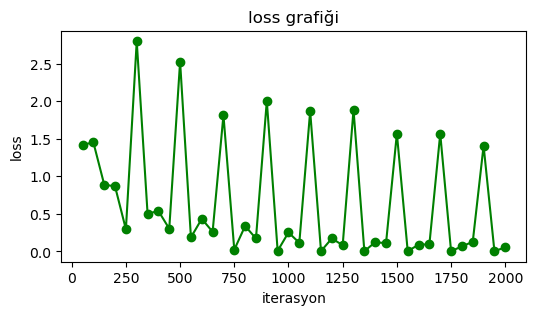

In [26]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(6,3))
plt.title("loss grafiği")
plt.plot(iterasyon,kayip,"-o",color="g")
plt.xlabel("iterasyon")
plt.ylabel("loss")
plt.show()


## Accuracy Görselleştirme

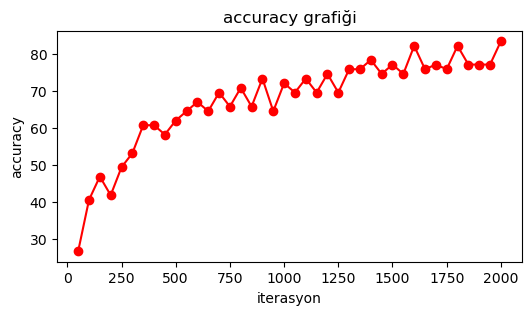

In [27]:
plt.figure(figsize=(6,3))
plt.title("accuracy grafiği")
plt.plot(iterasyon,accuracy_list,"-o",color="r")
plt.xlabel("iterasyon")
plt.ylabel("accuracy")
plt.show()

## Test Verisinden Tahmin 

In [28]:

def gorsellestirme(model, image_count=6):
    was_training=model.training
    model.eval()
    resim_sayisi=0
    with torch.no_grad():
        for i,(images,labels) in enumerate(test_loader):
            out=model(images)
            tahmin=torch.max(out,1)[1]
            for j in range(images.size()[0]):
                plt.figure(figsize=(20,10))
                resim_sayisi+=1
                ax=plt.subplot(image_count//2,2,resim_sayisi)
                ax.axis("off")
                ax.set_title(f"Tahmin: {classes[tahmin[j]]}")
                imshow(images.cpu().data[j])
                
                if resim_sayisi==image_count:
                    model.train(mode=was_training)
                    return
                

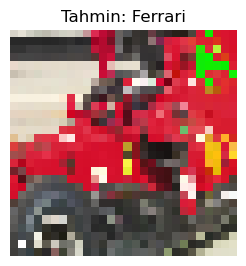

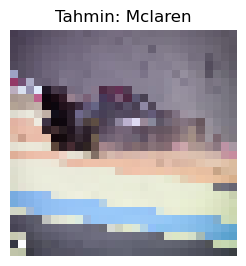

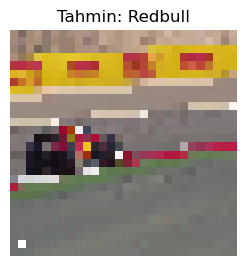

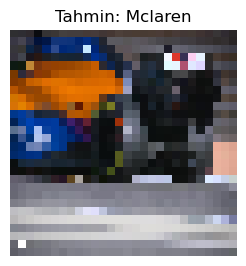

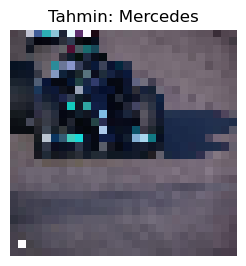

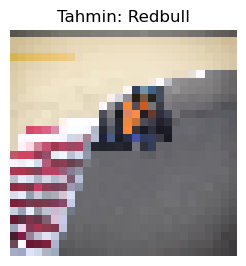

In [29]:
gorsellestirme(model1)